Training with RELU activation...
Training with SIGMOID activation...
Training with TANH activation...


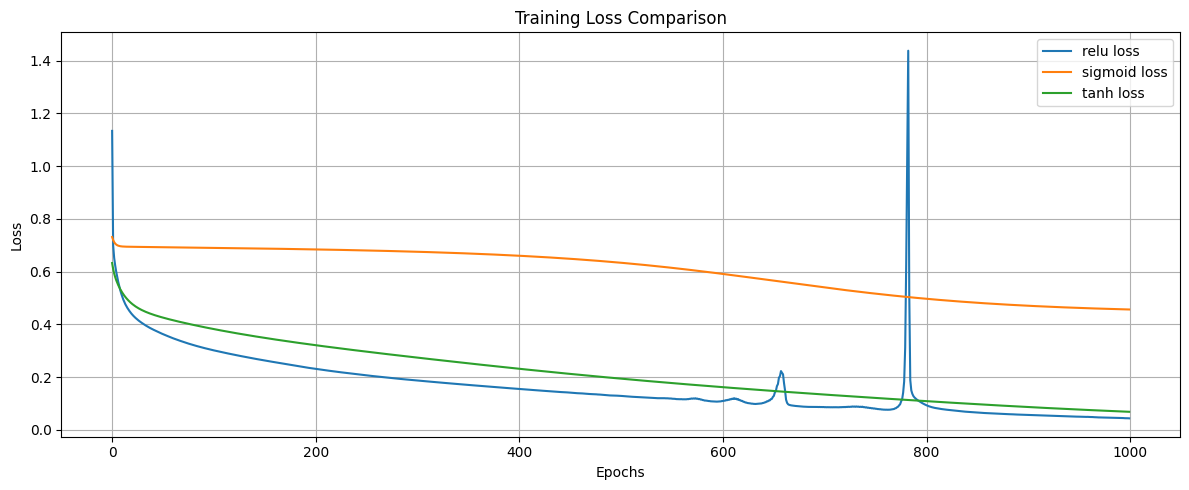

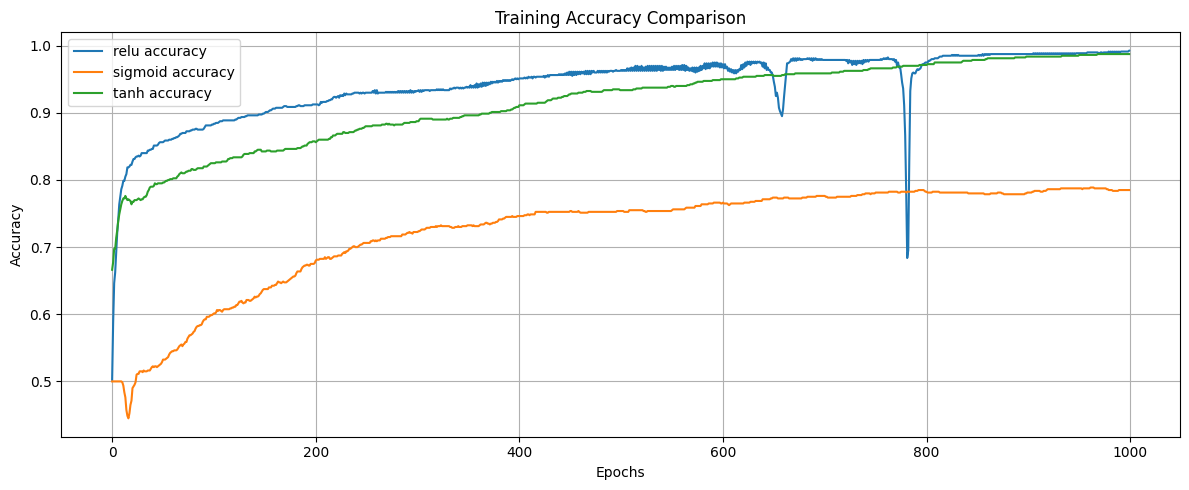


RELU Test Accuracy: 0.8850


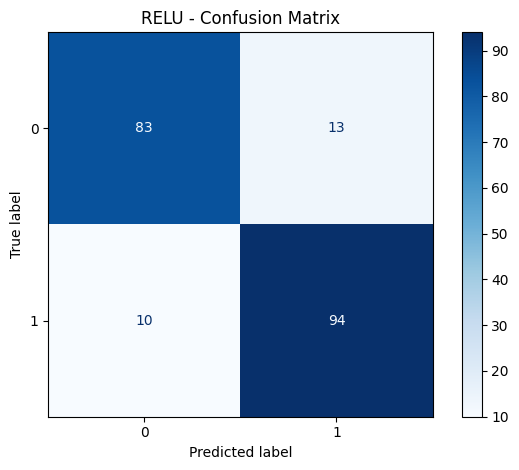


SIGMOID Test Accuracy: 0.8050


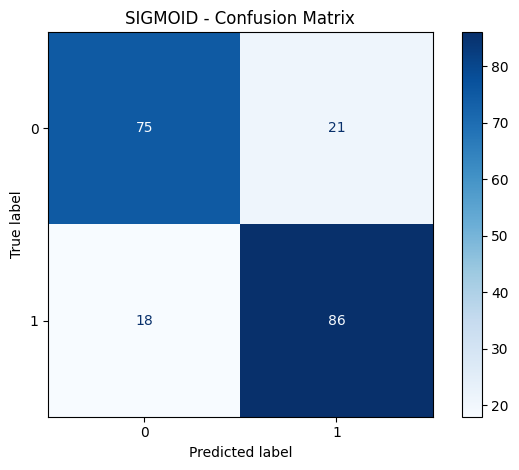


TANH Test Accuracy: 0.9100


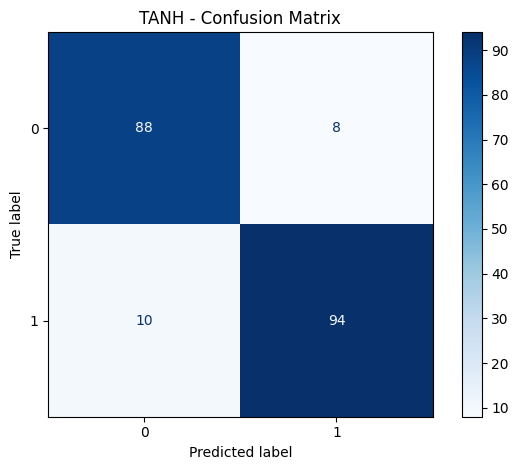

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# === Activation Functions and Derivatives ===
def relu(x): return np.maximum(0, x)
def relu_deriv(x): return (x > 0).astype(float)

def sigmoid(x): return 1 / (1 + np.exp(-x))
def sigmoid_deriv(x): return sigmoid(x) * (1 - sigmoid(x))

def tanh(x): return np.tanh(x)
def tanh_deriv(x): return 1 - np.tanh(x)**2

def get_activation(name):
    if name == 'relu':
        return relu, relu_deriv
    elif name == 'sigmoid':
        return sigmoid, sigmoid_deriv
    elif name == 'tanh':
        return tanh, tanh_deriv
    else:
        raise ValueError("Unsupported activation")

# === Parameter Initialization ===
def initialize_parameters(layer_sizes):
    params = {}
    for i in range(1, len(layer_sizes)):
        params[f'W{i}'] = np.random.randn(layer_sizes[i-1], layer_sizes[i]) * np.sqrt(2. / layer_sizes[i-1])
        params[f'b{i}'] = np.zeros((1, layer_sizes[i]))
    return params

# === Forward Pass ===
def forward_pass(X, params, activation_name):
    act_func, _ = get_activation(activation_name)
    cache = {'A0': X}
    L = len(params) // 2

    for i in range(1, L):
        Z = cache[f'A{i-1}'] @ params[f'W{i}'] + params[f'b{i}']
        A = act_func(Z)
        cache[f'Z{i}'], cache[f'A{i}'] = Z, A

    ZL = cache[f'A{L-1}'] @ params[f'W{L}'] + params[f'b{L}']
    AL = sigmoid(ZL)  # Output layer uses sigmoid for binary classification
    cache[f'Z{L}'], cache[f'A{L}'] = ZL, AL
    return cache

# === Backward Pass ===
def backward_pass(y, params, cache, activation_name):
    _, act_deriv = get_activation(activation_name)
    grads = {}
    L = len(params) // 2
    m = y.shape[0]

    dZL = cache[f'A{L}'] - y
    grads[f'dW{L}'] = cache[f'A{L-1}'].T @ dZL / m
    grads[f'db{L}'] = np.sum(dZL, axis=0, keepdims=True) / m

    dZL_temp = dZL
    for i in reversed(range(1, L)):
        dA = dZL_temp @ params[f'W{i+1}'].T
        dZ = dA * act_deriv(cache[f'Z{i}'])
        grads[f'dW{i}'] = cache[f'A{i-1}'].T @ dZ / m
        grads[f'db{i}'] = np.sum(dZ, axis=0, keepdims=True) / m
        dZL_temp = dZ

    return grads

# === Parameter Update ===
def update_parameters(params, grads, lr):
    L = len(params) // 2
    for i in range(1, L+1):
        params[f'W{i}'] -= lr * grads[f'dW{i}']
        params[f'b{i}'] -= lr * grads[f'db{i}']
    return params

# === Training Function ===
def train_model(X, y, layer_sizes, activation_name, epochs=1000, lr=0.1):
    params = initialize_parameters(layer_sizes)
    losses, accuracies = [], []

    for epoch in range(epochs):
        cache = forward_pass(X, params, activation_name)
        AL = cache[f'A{len(layer_sizes)-1}']
        loss = -np.mean(y * np.log(AL + 1e-8) + (1 - y) * np.log(1 - AL + 1e-8))
        acc = np.mean((AL > 0.5).astype(int) == y)

        losses.append(loss)
        accuracies.append(acc)

        grads = backward_pass(y, params, cache, activation_name)
        params = update_parameters(params, grads, lr)

    return params, losses, accuracies

# === Prediction ===
def predict(X, params, activation_name):
    cache = forward_pass(X, params, activation_name)
    return (cache[f'A{len(params)//2}'] > 0.5).astype(int)

# === Dataset Preparation ===
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    n_classes=2,
    n_clusters_per_class=2,
    flip_y=0.1,
    class_sep=1.0,
    random_state=42
)
y = y.reshape(-1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Model Configuration ===
layer_sizes = [10, 64, 32, 16, 1]
activations = ['relu', 'sigmoid', 'tanh']
results = {}

# === Train and Evaluate Models ===
for act in activations:
    print(f"Training with {act.upper()} activation...")
    params, losses, accs = train_model(X_train, y_train, layer_sizes, act, epochs=1000, lr=0.1)
    y_pred = predict(X_test, params, act)
    test_acc = accuracy_score(y_test, y_pred)
    results[act] = {
        'params': params,
        'losses': losses,
        'train_accs': accs,
        'y_pred': y_pred,
        'test_acc': test_acc
    }

# === Plot Training Loss ===
plt.figure(figsize=(12, 5))
for act in activations:
    plt.plot(results[act]['losses'], label=f"{act} loss")
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_loss_comparison.png')
plt.show()

# === Plot Training Accuracy ===
plt.figure(figsize=(12, 5))
for act in activations:
    plt.plot(results[act]['train_accs'], label=f"{act} accuracy")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_accuracy_comparison.png')
plt.show()

# === Show Test Accuracy and Confusion Matrices ===
for act in activations:
    print(f"\n{act.upper()} Test Accuracy: {results[act]['test_acc']:.4f}")
    cm = confusion_matrix(y_test, results[act]['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{act.upper()} - Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f'{act}_confusion_matrix.png')
    plt.show()


In [3]:
# prompt: print the accuracy for each activation function

for act in activations:
  print(f"\n{act.upper()} Test Accuracy: {results[act]['test_acc']:.4f}")


RELU Test Accuracy: 0.9050

SIGMOID Test Accuracy: 0.8150

TANH Test Accuracy: 0.8850
